# RSTT Tutorial

## Project description
#### League of Legends Global Power Ranking 
In September 2024, Riot Games introduced their **Global Power Ranking**, a [ranking](https://lolesports.com/en-US/news/dev-diary-unveiling-the-global-power-rankings) for professional League of Legends teams. At is core,  a modified Elo system modeling not only the teams, but also regions as part of an international eco-system.

Additionaly to the Global Power Ranking, we also build a simple **Calendar**. The Calendar responsability is to to generate a somewhat realistic/meaningfull synthetic dataset to evaluate ranking design.
By following the structure of *League of Legend* international competition, it produces data suited for the ranking considerations. You can find detail about it on [Liquipedia](https://liquipedia.net/leagueoflegends/Main_Page)

In this notebook, you will learn how to:
- Design a ranking in the spirit of the package
- Use and combine format of competition to create a complex calendar


The notebook from there on will simply refer to *GPR* for the ranking, and *LoL* for League of Legends

#### Tutorial Structure

The goal is to make the notebook work. To achieve this you need to implement several components of the rstt framework.


In the *project* forlder you'll find python module where you work on your implement.

## 1. Implementation of a Competition

[Competition](https://rstt.readthedocs.io/en/latest/rstt.scheduler.tournament.html#rstt.scheduler.tournament.competition.Competition) is an abstract class from which inherit tournament format such as [Round-Robin](https://rstt.readthedocs.io/en/latest/rstt.scheduler.tournament.html#rstt.scheduler.tournament.groups.RoundRobin) or [Single Elimination Bracket](https://rstt.readthedocs.io/en/latest/rstt.scheduler.tournament.html#rstt.scheduler.tournament.knockout.SingleEliminationBracket). The LoL calendar consist of events for which the rstt already provides a corresponding implementation. For tutorial purpose, we propose to work on a **StagedEvent** class (where different format are played in a succession of stages) to illustrate the devellopement process.

When working on a Competition, you want to be able to instanciate it with seedings, a solver and a name (used as identifier). You also want to 'register' participants and 'run' it. The following code snippet illustrate how the magic happends. It is **not** the exact implementation, but gives the necessary information to understand the logic of the class.

```python
def run(self):
    self.start(): ->
        self.seeding = self.seeding.fit(self.participants)
        self._initialise() # Optional Override (TODO ?)
    self.play(): ->
        while not self.finished:
            games = self.generate_games() # Abstract Method (TODO 1)
            games = self.play_games(games)
            self.edit(games): ->
                self.played_matches.append(games)
                self._update() # Optional Override (TODO ?)
                self.__finished = self._end_of_Stage() # Aabstract Method (TODO 2)
    self.trophies(): ->
        self._standing() # Abstract Method (TODO 3)
        for player in self.participants:
            player.collect(self)
```

In the project/stagedevent.py file there is a StageEvent class for you to fill. 

#### TODO:
Make sure the next cell is exectuable

In [1]:
from rstt import Player, BTRanking, BetterWin
from rstt import RoundRobin, SingleEliminationBracket, DoubleEliminationBracket

#from LoL.project.stagedevent import StagedEvent
from solutions.stagedevent import StagedEvent


# simulation parameters
teams = Player.create(nb=8)
gt = BTRanking(name='GroundTruth', players=teams)
solver = BetterWin()

# competition parameters
tournaments = [RoundRobin, SingleEliminationBracket, DoubleEliminationBracket]
names = ['PlayIns', 'MainStage', 'PlayOffs']

# try your implementation 
test = StagedEvent(name='test', seeding=gt, solver=solver, tournaments=tournaments, stage_names=names)
test.registration(teams)
test.run()

### 1.2. Competition Quality

In simulation, the role of a competition class is to output a small match dataset with a specific logic/structure and identify a winner among a predefine number of competitors. In our project, the resulting games are used to update the ranking, and the final placement is used to qualify teams to other events. These are two important features of the StagedEvent class. In the next cell we perform some 'integrity check' to ensure the implementation does what it is supposed to do.

#### TODO:
Ensure that:
- 1) Stages are properly executed: each started(), where played entirely and the trophies() method was properly called.
- 2) The competition returns the right amout of games
- 3) The competition correctly build the final standing


**TIP:**
A simulation using the BetterWin solver and players with constant level is deterministic and always produces the same output. You also know who is supposed to finish first and last thanks to the BTRanking class.

Feel free to change the test/requierements, as long as you do clearly define what your implementation should do!

In [2]:
# 1. check stages proper run
for stage in test.stages:
    print(stage.name(),'started:', stage.started(),
          '/ finished playing games:', not stage.live(),
          '/ closing ceremony done:', stage.over())

# 2. check return dataset
target_games = []
for i, tournament in enumerate(tournaments):
    stage = tournament(name=f'test_stage_games_{i}', seeding=gt, solver=solver)
    stage.registration(teams)
    stage.run()
    target_games += stage.games()
print('StagedEvent number of games correct:', len(test.games()) == len(target_games))

# 3. check final standing
final = tournaments[-1](name='test_final_stage_standing', seeding=gt, solver=solver)
final.registration(teams)
final.run()
print('StagedEvent final standing matches the final stage stading:', test.standing() == final.standing())

testPlayIns started: True / finished playing games: True / closing ceremony done: True
testMainStage started: True / finished playing games: True / closing ceremony done: True
testPlayOffs started: True / finished playing games: True / closing ceremony done: True
StagedEvent number of games correct: False
StagedEvent final standing matches the final stage stading: True


## 2. Implementation of a Ranking

[Ranking]() in rstt consists of:
- a [standing](): sorts automatically competitors accordingly to their ratings.
- a [datamodel](): container for rating.
- a [backend](): tool to infer ratings, 'the maths'. 
- an [handler](): a workflow handling the update from observations to new ratings.

It is possible to instanciate a ranking simply by specifying the suited components. However, it is also possible to inherit from the class and override the [forward](https://rstt.readthedocs.io/en/latest/rstt.ranking.html#rstt.ranking.ranking.Ranking.forward) method which allows us to tune the ranking state at update time. The following code snippet illustrate the default implementation.

```python
def update(self, *args, **kwargs):
    self.forward(*args, **kwargs) ->
        self.handler.handle_observation(infer=self.backend, datamodel=self.datamodel, *args, **kwargs)
    # automatic ordering of the standing
```

Two important remarks. First the ranking **does not care** about ratings explicitly. It is an implict agreement between the components. As long as the backend can manipulate the ratings provided by the handler (and returned by datamodel.get) it should work. It is recommanded to not 'hard code' ratings so that the ranking keeps maximal flexibility and that component remains as independant from each others as possible. Secondly, 'observations' - the things that justify a ranking update, passed as *args **kwargs - are dealt by the handler. The handler needs to extract the relevant information from it. You are free to decide what the ranking takes as input and how to process them.

#### 2.1 Global Power Ranking Logic and Structure

The GPR has its own specificity aswell. It rate leagues, this means we need dedicated Player to represent them because ranking and datamodel are designed for SPlayer. Ratings are evaluated game by game over a time window using an elo rational where games do not all have the same importance. These *extra* notions are develloped in the utils module.

- (A) 'league' players
- (B) a database
- (C) adjust game importance
- (D) reset ratings (so that only the game in the time period count)
- (E) identify the scene and stage (regional/international) of an event

In the turorial, we use a consistent naming convention (define in the scene module) for competition. This way we can extract the needed information to set the importance of the corresponding game. This mean the GPR will take an 'event: Event' parameter  for update (refered as observation). 



In [3]:
from solutions.globalranking import GlobalRanking
from solutions.scene import REGIONS
from solutions.utils import LeagueSystem

# teams
teams_by_leagues = {region: Player.create(nb=4) for region in REGIONS[:2]}
ecosystem = LeagueSystem(teams_by_leagues)

# ranking parameters
x, y, team_elo, league_elo = 0.8, 0.2, 1300, 1300
gpr = GlobalRanking(name='Global Power Ranking', ecosystem=ecosystem, x=x, y=y, team_elo=team_elo, league_elo=league_elo)
gpr.plot()

----------- Global Power Ranking -----------


In [4]:
# 1. check ranking empty (no games have been played, window is empty !)
print('Empty Ranking at instanciation:', len(gpr) == 0)

# 2. check the Power score formula
team = ecosystem.teams()[0] # a team from the system
rating = gpr.datamodel.get(team) # its rating
points = gpr.datamodel.ordinal(rating) # the associated score
print('Ordinal implements the Power Score Formula:', points == x*team_elo + y*league_elo)

Empty Ranking at instanciation: True
Ordinal implements the Power Score Formula: True


In [5]:
gt = BTRanking('Consensus Ranking', players=ecosystem.teams())
gt.plot()

----------- Consensus Ranking -----------
   0.        Joanne Juarez       1941
   1.        Raymond Black       1680
   2.        Ronald Gatesy       1492
   3.         Daniel Myers       1492
   4.         Pearl Rhodes       1183
   5.   Guadalupe Schuller        838
   6.       Trina Stephens        702
   7.        Donna Hickman        699


In [6]:
import json
from collections import defaultdict
from solutions.scene import LCK, LPL, LEC, LTAN, LTAS, LCP

import rstt.config as cfg

#region_mapping = defaultdict(lambda: LCP)
region_mapping = {}
region_mapping['NorthAmerica'] = LTAN
region_mapping['Europe'] = LEC
region_mapping['Korea'] = LCK
region_mapping['China'] = LPL
region_mapping['Brazil'] = LTAS
region_mapping['LatinAmerica'] = LTAS
region_mapping['AsiaPacific'] = LCP
region_mapping['Vietnam'] = LCP
region_mapping['Japan'] = LCP


# set default behaviour for Player class
cfg.PLAYER_DIST = lambda: 1000
cfg.PLAYER_DIST_ARGS = {}
teams = defaultdict(lambda: [])

# read data
with open('data/teams.json', 'r') as file:
    data = json.load(file)

# create player instance for each teams
for team in data['teams']:
    teams[region_mapping[team['region']]].append(Player(name=team['name'], level=team['level']))

# store in a league system
ecosystem = LeagueSystem(teams)

# display the population
for league, lts in teams.items():
    print(league, len(lts))

ecosystem.teams(LCP)
# TODO: some test like number of teams/regions league players etc

LTAN 8
LEC 10
LCK 10
LPL 17
LCP 20
LTAS 16


[Player - name: CTBC Flying Oyster, level: 1189,
 Player - name: Deep Cross Gaming, level: 1147,
 Player - name: Frank Esports, level: 1184,
 Player - name: HELL PIGS, level: 1063,
 Player - name: J Team, level: 1117,
 Player - name: PSG Talon, level: 1323,
 Player - name: West Point Esports, level: 1053,
 Player - name: CERBERUS Esports, level: 1077,
 Player - name: GAM Esports, level: 1254,
 Player - name: MGN Blue Esports, level: 1053,
 Player - name: Team Flash, level: 1069,
 Player - name: Team Secret, level: 1134,
 Player - name: Team Whales, level: 1128,
 Player - name: Vikings Esports, level: 1174,
 Player - name: AXIZ CREST, level: 1000,
 Player - name: Burning Core Toyama, level: 1000,
 Player - name: DetonatioN FocusMe, level: 1106,
 Player - name: Fukuoka HAWKS gaming, level: 1147,
 Player - name: Sengoku Gaming, level: 1125,
 Player - name: V3 Esports, level: 1000]

In [7]:
%%time

from solutions.utils import get_event_infos, EventInfos
from solutions.scene import AUDIENCE_MAPPING, REGIONAL, INTERNATIONAL, STAGES, FINALS
from solutions.calendar import calendar, event_qualification, year_schedule

from rstt import LogSolver, BasicElo

# population

# ranking 'elo' params
team_elo = 1300
league_elo = 1300
lc = 40

# window params
ly = len(year_schedule(0,1)) # event per year
stage_per_event = 3
team_years = 2 # nb year for the team rating window
league_years = 3 # nb year for the league rating window
window_ranges = {'Team': team_years*ly*stage_per_event, 'League': league_years*ly*stage_per_event}

# power score params
x = 0.8 # weight of team rating
y = 0.2 # weight of league rating

# rankings
gt = BTRanking('GroundTruth', players=ecosystem.teams())
elo = BasicElo('Elo Baseline', players=ecosystem.teams())
gpr = GlobalRanking(name='Global Power Ranking', ecosystem=ecosystem, x=x, y=y, team_elo=team_elo, league_elo=league_elo, lc=lc, mode_range=window_ranges)

# calendar parameters
start = 2024
duration = 2
#with open('data/qualifications.json', 'r') as file:
#    qualif_data = json.load(file)


# result tracking
ranking_state = {elo.name: [], gpr.name: [], gt.name: []}


# Simulation
for event in calendar(start, start+duration, solver=LogSolver(lc=600), seeding=gpr, source='data/qualifications.json'):
    infos = get_event_infos(event)
    invitations, qualifications = event_qualification(infos, ecosystem, gpr.dataset, source='data/qualifications.json')
    event.registration(invited=invitations, qualified=qualifications)
    event.run()

    if infos.region in FINALS:
        print(event.name())
        
        gpr.update(event=None)
        ranking_state[elo.name].append([elo.point(team) for team in ecosystem.teams()])
        ranking_state[gpr.name].append([gpr.point(team) for team in ecosystem.teams()])
        ranking_state[gt.name].append([gt.point(team) for team in ecosystem.teams()])
    
    for stage in event.stages:
        elo.update(games=stage.games())
        gpr.dataset.add(stage)

    if infos.region in FINALS:
        gpr.update(event=None)
        ranking_state[elo.name].append([elo.point(team) for team in ecosystem.teams()])
        ranking_state[gpr.name].append([gpr.point(team) for team in ecosystem.teams()])
        ranking_state[gt.name].append([gt.point(team) for team in ecosystem.teams()])



FirstStand Winter 2024 
MSI Spring 2024 
Worlds Summer 2024 
FirstStand Winter 2025 
MSI Spring 2025 
Worlds Summer 2025 
CPU times: user 5.8 s, sys: 26.3 ms, total: 5.83 s
Wall time: 5.84 s


In [8]:
from scipy import stats

corr = {gpr.name: [stats.kendalltau(x, y)[0] for x,y in zip(ranking_state[gpr.name], ranking_state[gt.name])],
        elo.name: [stats.kendalltau(x, y)[0] for x,y in zip(ranking_state[elo.name], ranking_state[gt.name])]}

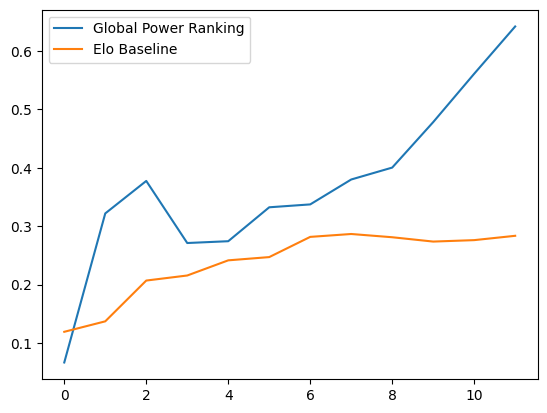

In [9]:
import matplotlib.pyplot as plt

plt.plot(corr[gpr.name], label=gpr.name)
plt.plot(corr[elo.name], label=elo.name)
plt.legend()

In [10]:
top = 10
stats.kendalltau(elo[gt[:top]], gt[gt[:top]])

SignificanceResult(statistic=np.float64(0.6888888888888888), pvalue=np.float64(0.00468694885361552))

In [11]:
top = 10
stats.kendalltau(gpr[gt[:top]], gt[gt[:top]])

SignificanceResult(statistic=np.float64(0.28888888888888886), pvalue=np.float64(0.2912483465608466))

In [12]:
gpr[gt[:top]]

[4, 6, 3, 0, 1, 19, 14, 8, 12, 11]

In [13]:
from rstt import Ranking

def accuracy(ref: Ranking, test: Ranking, top: int):
    targets = ref[:top]
    predict = test[:top]
    positive = [p for p in predict if p in targets]
    return len(positive)/len(targets)

print(accuracy(gt, elo, 10), accuracy(gt, gpr, 10))

0.7 0.6


In [14]:
gt.plot()

----------- GroundTruth -----------
   0.        Gen.G Esports       1663
   1.      Bilibili Gaming       1602
   2.  Hanwha Life Esports       1572
   3.          Top Esports       1508
   4.           G2 Esports       1478
   5.                   T1       1467
   6.                Dplus       1445
   7.            JD Gaming       1440
   8.           KT Rolster       1410
   9.          LNG Esports       1407
  10.         Weibo Gaming       1391
  11.    Ninjas in Pyjamas       1376
  12.               Fnatic       1372
  13.          Team Liquid       1362
  14.      Anyone's Legend       1352
  15.             Team BDS       1344
  16.             FlyQuest       1342
  17.            PSG Talon       1323
  18.      FunPlus Phoenix       1320
  19.              Team WE       1310
  20.               Freecs       1309
  21.           LGD Gaming       1307
  22.        MAD Lions KOI       1302
  23.            Oh My God       1299
  24.               Cloud9       1299
  25.         

## Simulation Model

In [46]:
from solutions.models import Role, MetaData, LoLTeam, LoLSolver
from rstt import GaussianPlayer, Duel

roles = {r: w for r, w in zip(Role, [0.1, 0.25, 0.2, 0.3, 0.15])}
blue = GaussianPlayer('BlueSide', mu=1500, sigma=75)
red = GaussianPlayer('RedSide', mu=1500, sigma=75)
meta = MetaData(roles, blue, red)
solver = LoLSolver(meta=meta)


In [52]:
team1 = LoLTeam('TeamBlue', {r: Player('dummy', 1641) for r in Role})
team2 = LoLTeam('TeamRed', {r: Player('dummy', 1500) for r in Role})

for _ in range(20):
    meta.update({})
    print(meta.blue().level() - meta.red().level(), solver.probabilities(Duel(team1, team2)))

1.9745028479064786 [0.633830431295863, 0.3661695687041369]
-93.02141088461462 [0.5459015541533843, 0.45409844584661574]
187.17853635234405 [0.778928258467128, 0.22107174153287198]
61.35180131984748 [0.6849368901653827, 0.3150631098346173]
91.63580281117629 [0.7094620672894432, 0.2905379327105569]
7.03235369014601 [0.6383235252171606, 0.3616764747828394]
130.77730165991557 [0.7394253486509589, 0.2605746513490411]
20.294460487353263 [0.6499888885368625, 0.3500111114631374]
24.331813497555686 [0.653505562987143, 0.346494437012857]
6.234893078597679 [0.637616689743641, 0.3623833102563589]
100.89226260286227 [0.7167294252424954, 0.2832705747575046]
62.48164887813414 [0.6858718298871632, 0.3141281701128368]
-141.88220949894503 [0.4991535997913217, 0.5008464002086782]
3.7849510165783613 [0.6354414496553795, 0.36455855034462054]
-181.8689597257728 [0.46087007270049835, 0.5391299272995016]
-90.02408661557456 [0.54875144670459, 0.4512485532954101]
23.558063128527692 [0.652832882938486, 0.3471671

In [53]:
team1.level(meta.weights())

1641.0